# 构建网络

构建网络的必备基础模块 —— nn.Module 模块。

## 构建模型

使用 PyTorch，自己构建并训练一个线性回归模型，来拟合出训练集中的走势分布。

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

import torch
from torch import nn

from IPython.display import display

torch.__version__

'1.13.0'

随机生成训练集 X 与对应的标签 Y，具体代码如下：

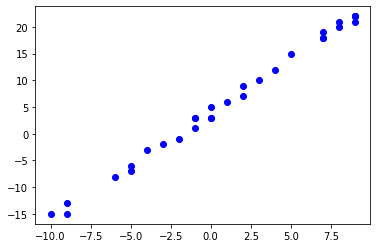

In [2]:
w = 2
b = 3
xlim = [-10, 10]

x_train = np.random.randint(low=xlim[0], high=xlim[1], size=30)
# y = wx + b
y_train = [w * x + b + random.randint(0, 2) for x in x_train]

plt.plot(x_train, y_train, 'bo')

构建这个模型

In [3]:
class LinearModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, input):
        return self.weight * input + self.bias


引出构建网络时的几个重要的知识点：
1. 必须继承 nn.Module 类。
2. 重写 `__init__()` 方法。通常来说要把有需要学习的参数的层放到构造函数中，例如，例子中的 weight 与 bias，还有卷积层。nn.Parameter()，它主要的作用就是作为 nn.Module 中可训练的参数使用。
3. forward() 是必须重写的方法。它是用来定义这个模型是如何计算输出的，也就是前向传播。对应到例子，就是获得最终输出 `y= weight * x + bias` 的计算结果。对于一些不需要学习参数的层，一般来说可以放在这里。例如，BN 层、激活函数还有 Dropout。

**nn.Module 模块**

nn.Module 是所有神经网络模块的基类。其实 Torchvison 中的那些模型，也都是通过继承 nn.Module 模块来构建网络模型的。

模块本身是 callable 的，当调用它的时候，就是执行 forward 函数，也就是前向传播。

nn.Module 的 `__init__()` 中，会初始化一些有序的字典与集合。这些集合用来存储一些模型训练过程的中间变量，如果不初始化 nn.Module 中的这些参数的话，模型就会报错。如 `AttributeError: cannot assign parameters before Module.__init__() call`

In [4]:
model = LinearModel()
x = torch.tensor(3)
y = model(x)


## 训练模型

模型定义好之后，需要训练模型。需要用到损失函数与优化方法，这里选择的是 MSE 损失与 SGD 优化方法。

In [5]:
model = LinearModel()
# 定义 优化方法
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)

y_train = torch.tensor(y_train, dtype=torch.float32)
# 1000 个 Epoch 的训练
for _ in range(1000):
    input = torch.from_numpy(x_train)
    ouput = model(input)
    loss = nn.MSELoss()(ouput, y_train)
    model.zero_grad()
    loss.backward()
    optimizer.step()


对于一个模型的可训练的参数，可以通过 named_parameters() 来查看：

In [6]:
for parameter in model.named_parameters():
    print(parameter)

('weight', Parameter containing:
tensor([2.0175], requires_grad=True))
('bias', Parameter containing:
tensor([3.5604], requires_grad=True))


## 模型保存与加载

训练好的模型最终的目的是要为其他应用提供服务，这就涉及到了模型的保存与加载。
模型保存与加载有两种方式。PyTorch 模型的后缀名一般是 pt 或 pth，两者相同，只是一个后缀名而已。

### 方式一：只保存训练好的参数

这种方式加载模型的时候，需要通过代码加载网络结构，然后再将参数赋予网络。

In [7]:
model_file = './models/linear_model.pth'

# 第一个参数是模型的 state_dict
# 第二个参数要保存的位置
torch.save(model.state_dict(), model_file)

state_dict 是一个字典，在模型被定义之后会自动生成，存储的是模型可训练的参数。

In [8]:
model.state_dict()

OrderedDict([('weight', tensor([2.0175])), ('bias', tensor([3.5604]))])

加载模型的方式如下

In [9]:
# 定义模型
linear_model = LinearModel()

# 加载模型参数
linear_model.load_state_dict(torch.load(model_file))
linear_model.eval()

for parameter in linear_model.named_parameters():
    print(parameter)

('weight', Parameter containing:
tensor([2.0175], requires_grad=True))
('bias', Parameter containing:
tensor([3.5604], requires_grad=True))


### 方式二：保存网络结构与参数

这种方式在加载模型的时候，不需要加载网络结构了。保存和加载的代码如下：

In [10]:
model_file_with_arc = './models/linear_model_with_arc.pth'
torch.save(model, model_file_with_arc)

linear_model2 = torch.load(model_file_with_arc)
linear_model2.eval()

for parameter in linear_model2.named_parameters():
    print(parameter)

('weight', Parameter containing:
tensor([2.0175], requires_grad=True))
('bias', Parameter containing:
tensor([3.5604], requires_grad=True))


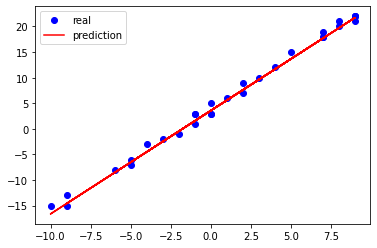

In [11]:
# compare result

predict_w = linear_model2.get_parameter(target="weight").data.item()
predict_b = linear_model2.get_parameter(target="bias").data.item()
y = predict_w * x_train + predict_b

plt.plot(x_train, y_train, 'bo', label="real")
plt.plot(x_train, y, c='r', label='prediction')
plt.legend()

## 网络模型组合

继承一个 nn.Module 之后，可以定义自己的网络模型。也可以将它作为另外一个 Module 的一部分，被包含在网络中。

举个例子：

<img src="https://static001.geekbang.org/resource/image/25/c6/2574b93463fd3dbd0e97661d6a06ffc6.jpg?wh=1372x689" width="50%" />

图中的 3x3 与 2x2 的卷积组合，需要把每一层卷积都定义到 `__init__()`，然后再在 `forward` 中定义好执行方法就可以了，例如下面的伪代码：

```python
class CustomModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same')
    self.conv1_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=2, padding='same')
    ...
    self.conv_m_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same')
    self.conv_m_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=2, padding='same')
    ...
    self.conv_n_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same')
    self.conv_n_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=2, padding='same')

  def forward(self, input):
    x = self.conv1_1(input)
    x = self.conv1_2(x)
    ...
    x = self.conv_m_1(x)
    x = self.conv_m_2(x)
    ...    
    x = self.conv_n_1(x)
    x = self.conv_n_2(x)
    ...
    return x
```

把重复的结构放在一个单独的 module 中，然后在模型中直接调用。代码参考如下：

```python
class CustomModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = CustomLayer(1，1)
    ...
    self.layerm = CustomLayer(1，1)
    ...
    self.layern = CustomLayer(1，1)
  
  def forward(self, input):
    x = self.layer1(input)
    ...
    x = self.layerm(x)
    ...    
    x = self.layern(x)
    ...
    return x
```

## 使用 Torchvison 中的模型进行训练

Torchvision 提供了一些封装好的网络结构，可以直接使用。

### 实例：使用 Torchvision 中模型进行微调

对于微调，最关键的一步就是调整最后全连接层输出的数目。Torchvision 中只是对各大网络结构的复现，而不是对它们进行了统一的封装，所以在修改全连接层时，不同的网络有不同的修改方法。


导入模型，如下：

In [12]:
from PIL import Image
import torchvision
from torchvision import models, transforms

In [13]:
# from torchvision.models.alexnet import AlexNet_Weights 

# # 这一步需要“科学上网”，否则非常慢
# # alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)
# alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

或者直接加载预先训练的模型

In [35]:
model_file_alexnet = './models/alexnet_model.pth'

# # 可以保存模型参数
# torch.save(alexnet.state_dict(), alexnet_model_file)

# 加载预训练模型
alexnet = models.alexnet()
alexnet.load_state_dict(torch.load(model_file_alexnet))

<All keys matched successfully>

对图形进行预测

In [ ]:
# 加载图片
im = Image.open('../res/images/dog.jpg')
display(im)

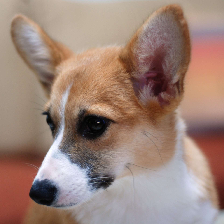

In [16]:
# corp_transform = transforms.RandomResizedCrop((224,224))
corp_transform = transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST)
corp_transform(im)

In [36]:
# Tensor 变换
# 将图片 resize 到 224x224 大小，这个尺寸是 Torchvision 中推荐的一个最小训练尺寸。
transform = transforms.Compose([
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 增加一个通道
input_tensor = transform(im).unsqueeze(0)

# 类别标签，参考 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# 263: 'Pembroke, Pembroke Welsh corgi'
alexnet(input_tensor).argmax()


tensor(263)

In [18]:
transform(im).size()

torch.Size([3, 224, 224])

预测结果标签是 263 

这个过程中有两个重点：

首先，因为 Torchvision 中所有图像分类的预训练模型，它们都是在 ImageNet 上训练的。所以，输入数据需要是 3 通道的数据，也就是 shape 为 (B, 3, H, W) 的 Tensor，B 为 batchsize 。需要使用均值为[0.485, 0.456, 0.406]，标准差为[0.229, 0.224, 0.225]对数据进行正规化。

>这里的均值和标准差指的是图像集 ImageNet 的

另外，从理论上说，大部分的经典卷积神经最后采用全连接层（也就是机器学习中的感知机）进行分类，这也导致了网络的输入尺寸是固定的。但是，在 Torchvision 的模型可以接受任意尺寸的输入的。
这是因为 Torchvision 对模型做了优化，有的网络是在最后的卷积层采用了全局平均，或者采用的是全卷积网络。这两种方式都可以让网络接受在最小输入尺寸基础之上，任意尺度的输入。

### 实例：使用 CIFAR-10 公开数据集

CIFAR-10 数据集一共有 60000 张图片构成，共 10 个类别，每一类包含 6000 图片。每张图片为 32x32 的 RGB 图片。其中 50000 张图片作为训练集，10000 张图片作为测试集。

使用 make_grid 方法，将 CIFAR-10 的数据打印出来，代码如下：

In [19]:
from torch.utils.data import DataLoader
from torchvision import datasets

In [20]:
cifar10_ds = datasets.CIFAR10(
    root='./ds',
    # train=False 代表使用非训练集，也就是测试集，10000张图片
    train=False,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=False)

tensor_dataloader = DataLoader(dataset=cifar10_ds, batch_size=160)

data_iter = iter(tensor_dataloader)
# img_tensor, label_tensor = data_iter.__next__()
img_tensor, label_tensor = next(data_iter)
print(img_tensor.shape)

torch.Size([160, 3, 32, 32])


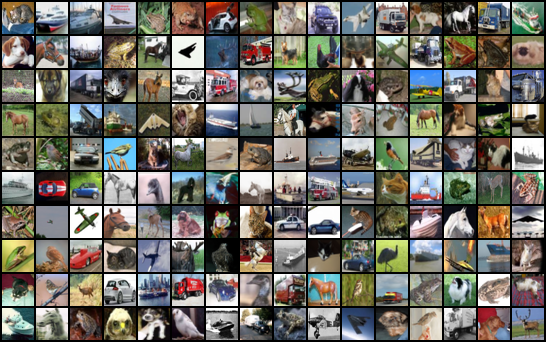

In [21]:
# display images

grid_tensor = torchvision.utils.make_grid(img_tensor, nrow=16, padding=2)
grid_img = transforms.ToPILImage()(grid_tensor)
display(grid_img)

打印出网络结构

In [22]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

可以看到，最后全连接层输入是 4096 个单元，输出是 1000 个单元，把它修改为输出是 10 个单元的全连接层（因为 CIFR10 有 10 类）。

In [23]:
fc_in_features = alexnet.classifier[6].in_features

alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

输出就变为 10 个单元了。现在可以使用 AlexNet 作为预训练模型训练自己的模型了。


读入数据

In [24]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cifar10_ds = datasets.CIFAR10(root='./ds', train=False, transform=transform, target_transform=None, download=False)

dataloader = DataLoader(dataset=cifar10_ds, batch_size=32, shuffle=True, num_workers=2)

定义优化器

In [25]:
optimizer = torch.optim.SGD(alexnet.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)

开始模型训练

In [26]:
for epoch in range(3):
    for item in dataloader:
        ouput = alexnet(item[0])
        target = item[1]
        # 
        loss = nn.CrossEntropyLoss()(ouput, target)
        print('Epoch: {}, Loss: {}'.format(epoch+1, loss))
        alexnet.zero_grad()
        loss.backward()
        optimizer.step()

# 这个步骤将会执行数分钟，打印出如下 epoch 和 loss
# Epoch: 1, Loss: 2.545963764190674
# Epoch: 1, Loss: 2.4982569217681885
# ...
# Epoch: 1, Loss: 1.2365844249725342
# Epoch: 1, Loss: 1.2775250673294067
# Epoch: 2, Loss: 1.0116748809814453
# Epoch: 2, Loss: 1.0246703624725342
# ...
# Epoch: 2, Loss: 1.0213570594787598
# Epoch: 2, Loss: 0.8635428547859192
# Epoch: 3, Loss: 1.2238523960113525
# Epoch: 3, Loss: 0.9763630628585815
# ...
# Epoch: 3, Loss: 1.1769508123397827
# Epoch: 3, Loss: 0.9684327244758606

保存训练好的模型参数

In [32]:
model_file_cifar10_my = './models/cifar10_my_model.pth'

torch.save(alexnet.state_dict(), model_file_cifar10_my)


使用训练模型

In [33]:
alexnet = models.alexnet()
# print(alexnet)

fc_in_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10)
# print(alexnet)

alexnet.load_state_dict(torch.load(model_file_cifar10_my))
for param in alexnet.parameters():
    param.requires_grad = False

预测

In [34]:
transform = transforms.Compose([
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

input_tensor = transform(im).unsqueeze(0)

# 类别标签，参考 https://www.cs.toronto.edu/~kriz/cifar.html
alexnet(input_tensor).argmax()

tensor(5)